In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cv
import pandas as pd
import scipy
import time
import gurobipy as gp
from gurobipy import GRB
from ast import literal_eval
import plotly
import plotly.graph_objects as go

# Results

## LP results

In [2]:
def convert(x):
    """Converts strings into list entries when reading dataframe"""
    try:
        return literal_eval(x)
    except:
        return np.NaN

# converters
labels_cast_concat = ['k1'] + [f'mu_{k}' for k in range(1, 141)]
converters_cast_concat = {label: convert for label in labels_cast_concat}

labels_cast_mesc = ['k1'] + [f'mu_{k}' for k in range(1, 154)]
converters_cast_mesc = {label: convert for label in labels_cast_mesc}

labels_c57_concat = ['k1'] + [f'mu_{k}' for k in range(1, 193)]
converters_c57_concat = {label: convert for label in labels_c57_concat}

labels_c57_mesc = ['k1'] + [f'mu_{k}' for k in range(1, 120)]
converters_c57_mesc = {label: convert for label in labels_c57_mesc}

# read in datasets
LP_cast_concat = pd.read_csv("..\Final_data\LP_cast_concat.csv", index_col="Unnamed: 0", converters=converters_cast_concat)
LP_cast_mesc = pd.read_csv("..\Final_data\LP_cast_mesc.csv", index_col="Unnamed: 0", converters=converters_cast_mesc)
LP_c57_concat = pd.read_csv("..\Final_data\LP_c57_concat.csv", index_col="Unnamed: 0", converters=converters_c57_concat)
LP_c57_mesc = pd.read_csv("..\Final_data\LP_c57_mesc.csv", index_col="Unnamed: 0", converters=converters_c57_mesc)

## NLP results

In [24]:
# read in datasets
NLP_cast_concat = pd.read_csv(r"..\Final_data\NLP_cast_concat.csv", index_col="Unnamed: 0", converters=converters_cast_concat)
NLP_cast_mesc = pd.read_csv(r"..\Final_data\NLP_cast_mesc.csv", index_col="Unnamed: 0", converters=converters_cast_mesc)
NLP_c57_concat = pd.read_csv(r"..\Final_data\NLP_c57_concat.csv", index_col="Unnamed: 0", converters=converters_c57_concat)
NLP_c57_mesc = pd.read_csv(r"..\Final_data\NLP_c57_mesc.csv", index_col="Unnamed: 0", converters=converters_c57_mesc)

# remove null values in k1 columns
nulls_cast_concat = NLP_cast_concat[NLP_cast_concat['k1'].apply(type) == float].shape[0]
NLP_cast_concat.loc[NLP_cast_concat['k1'].apply(type) == float, 'k1'] = [[None, None] for x in range(nulls_cast_concat)]

nulls_cast_mesc = NLP_cast_mesc[NLP_cast_mesc['k1'].apply(type) == float].shape[0]
NLP_cast_mesc.loc[NLP_cast_mesc['k1'].apply(type) == float, 'k1'] = [[None, None] for x in range(nulls_cast_mesc)]

nulls_c57_concat = NLP_c57_concat[NLP_c57_concat['k1'].apply(type) == float].shape[0]
NLP_c57_concat.loc[NLP_c57_concat['k1'].apply(type) == float, 'k1'] = [[None, None] for x in range(nulls_c57_concat)]

nulls_c57_mesc = NLP_c57_mesc[NLP_c57_mesc['k1'].apply(type) == float].shape[0]
NLP_c57_mesc.loc[NLP_c57_mesc['k1'].apply(type) == float, 'k1'] = [[None, None] for x in range(nulls_c57_mesc)]

# Categorization

Categorize genes into: 
- feasible / infeasible
- zero / non-zero lower bounds
- decreasing / increasing upper bounds
- mixture of upper bounds
- baynorm agreement

## Baynorm estimates

Baynorm assumes a negative binomial prior for the true count (stationary) distribution, estimating the parameters from data. Assuming a geometric burst distribution, the stationary distribution of the bursting model is negative binomial and so by comparing parameters we can obtain a point estimate of the geometric parameter / distribution of bursts.

Baynorm estimates scale $\phi_{i}$ and mean $\mu_{i}$ for each gene i, giving estimates of the relative burst frequency $\bar{a}$ and mean burst size $\bar{b}$:

$$ \bar{a} = \frac{k_0}{k_1} = \phi_{i} $$

$$ \bar{b} = \frac{\mu_{i}}{\phi_{i}} $$

and so burst distribution:

$$ B \sim \text{Geometric}(\frac{1}{\bar{b}}) = \text{Geometric}(\frac{\phi{i}}{\mu_{i}}) $$

In [11]:
# load prior estimates
prior_cast_concat = pd.read_csv("..\Final_data\prior_cast_concat.csv", index_col="Unnamed: 0")
prior_cast_mesc = pd.read_csv("..\Final_data\prior_cast_mesc.csv", index_col="Unnamed: 0")
prior_c57_concat = pd.read_csv("..\Final_data\prior_c57_concat.csv", index_col="Unnamed: 0")
prior_c57_mesc = pd.read_csv("..\Final_data\prior_c57_mesc.csv", index_col="Unnamed: 0")

# calculate b estimates
prior_cast_concat['B_EST'] = prior_cast_concat['MME_MU'] / prior_cast_concat['MME_SIZE']
prior_cast_mesc['B_EST'] = prior_cast_mesc['MME_MU'] / prior_cast_mesc['MME_SIZE']
prior_c57_concat['B_EST'] = prior_c57_concat['MME_MU'] / prior_c57_concat['MME_SIZE']
prior_c57_mesc['B_EST'] = prior_c57_mesc['MME_MU'] / prior_c57_mesc['MME_SIZE']

# display
prior_cast_concat.head()

,MME_MU,MME_SIZE,B_EST
0610007P14Rik,43.798180,0.648610,67.526236
0610009B22Rik,70.083391,0.999097,70.146768
0610031J06Rik,264.721377,3.455259,76.614040
1110007C09Rik,68.418706,0.636294,107.526887
1110012L19Rik,16.987593,0.439295,38.670142


In [130]:
def plot_dist(bounds, b_est=None, color="orange", show=True, label="Method"):
    # drop k0 and k1 entries
    bounds = bounds[2:]
    # extract upper and lower bounds
    labels = []
    lower = []
    upper = []
    baynorm_est = []
    for i, bound in enumerate(bounds):
        try:
            lower.append(bound[0])
            upper.append(bound[1])
            labels.append(f'mu_{i + 1}')
            if b_est:
                baynorm_est.append((1 / b_est) * (1 - (1 / b_est))**i)
        except:
            break
    # plot
    if b_est:
        plt.plot(labels, baynorm_est, color="red", label="BayNorm")
        plt.scatter(labels, baynorm_est, color="red")
    plt.plot(labels, upper, color=color, label=label)
    plt.plot(labels, lower, color=color)
    plt.scatter(labels, upper, color=color)
    plt.scatter(labels, lower, color=color)
    plt.title("Bounds on Burst distribution")
    plt.ylabel("Probability")
    plt.xlabel("Burst distribution")
    plt.legend()
    if show:
        plt.show()

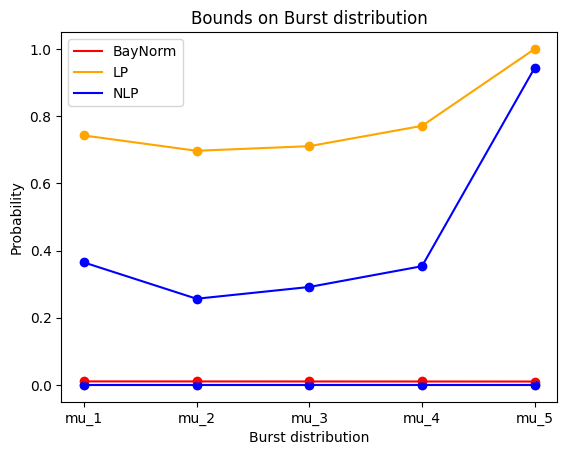

In [132]:
i = 328
result = LP_cast_concat.iloc[i]
result_NLP = NLP_cast_concat.iloc[i]
b_est = prior_cast_concat.iloc[i]['B_EST']
plot_dist(result, b_est=b_est, label="LP", show=False)
plot_dist(result_NLP, color="blue", label="NLP", show=True)

## Pipeline

In [101]:
def categorize(data, priors, zero_tolerance=10**(-2), monotone_tolerance=10**(-2), baynorm_tolerance=10**(-2)):
    
    def zero_lb(row, tolerance=zero_tolerance):
        """Boolean indicator: all lower bounds within tolerance of 0"""
        # return nan if infeasible
        if row['k1'][0] is None:
            return np.nan
        # examine mu bounds
        for bounds in row[2:]:
            try:
                lb = bounds[0]
                if lb > tolerance:
                    # exists a lower bound outside tolerance of zero
                    return False
            except:
                # nan: mu not estimated
                break
        # no faults found: return True
        return True

    def monotone_ub(row, decreasing=True, tolerance=monotone_tolerance):
        """
        Boolean indicator if upper bounds of dist. are montone (weakly)

        row: row of data containing lists of bounds on parameters + nan values
        decreasing:
            (True) return bool of whether upper bounds are weakly decreasing
            (False) return bool of whether upper bounds are weakly increasing
        """
        if decreasing:
            # arbitrary high value
            ub_prev = 10
        else:
            # arbitrarily low value
            ub_prev = -10
        # return nan if infeasible
        if row['k1'][0] is None:
            return np.nan
        # examine mu bounds
        for bounds in row[2:]:
            try:
                ub = bounds[1]
                # if ub increases by more than tolerance => not decreasing
                if ub > ub_prev + tolerance and decreasing:
                    return False
                # if ub decreases by more than tolerance => not increasing
                elif ub < ub_prev - tolerance and not decreasing:
                    return False
                else:
                    ub_prev = ub
            except:
                # nan: mu not estimated
                break
        # no faults found: return True
        return True

    def baynorm_agreement(row, tolerance=baynorm_tolerance):
        """Boolean indicator if baynorm estimated burst dist within bounds"""
        # return nan if infeasible
        if row['k1'][0] is None:
            return np.nan
        # baynorm estimate
        idx = row.name
        b_est = priors.iloc[idx]['B_EST']
        # examine mu bounds
        for i, bounds in enumerate(row[2:]):
            try:
                lb = bounds[0]
                ub = bounds[1]
                dist = (1 / b_est) * (1 - (1 / b_est))**i
                if lb > dist + tolerance or dist > ub + tolerance:
                    # dist outside of tolerance of bounds
                    return False
            except:
                # nan: mu not estimated
                break
        # no faults found: return True
        return True

    # create dataframe
    data_categories = pd.DataFrame()

    # boolean: infeasible bounds
    mask_infeasible = data['k1'].apply(lambda x: None in x)
    data_categories["infeasible"] = mask_infeasible

    # boolean: zero lower bounds
    mask_zero = data.apply(zero_lb, axis='columns')
    data_categories["zero_lb"] = mask_zero

    # boolean: monotone (increasing/decreasing) bounds
    mask_dec = data.apply(monotone_ub, args=(True,), axis='columns')
    mask_inc = data.apply(monotone_ub, args=(False,), axis='columns')
    data_categories["decreasing_ub"] = mask_dec
    data_categories["increasing_ub"] = mask_inc

    # boolean: consistent with baynorm estimate
    mask_bay = data.apply(baynorm_agreement, axis='columns')
    data_categories["baynorm_consistent"] = mask_bay

    return data_categories

In [102]:
def summary_statistics(cat):
    total = cat.shape[0]
    infeasible = cat['infeasible'].sum()
    feasible = total - infeasible
    zero_lb = cat['zero_lb'].sum()
    non_zero_lb = feasible - zero_lb
    # within tolerance of non-increasing and non-decreasing => flat
    flat_ub = (cat['decreasing_ub'] + cat['increasing_ub'] == 2).sum()
    # only increasing / decreasing
    increasing_ub_only = cat['increasing_ub'].sum() - flat_ub
    decreasing_ub_only = cat['decreasing_ub'].sum() - flat_ub
    # outside tolerance of non-increasing and non-decreasing => peak / trough
    #mixed_ub = feasible - (flat_ub + increasing_ub_only + decreasing_ub_only)
    mixed_ub = (cat['decreasing_ub'] + cat['increasing_ub'] == 0).sum()
    # agreement with baynorm
    baynorm_agree = cat['baynorm_consistent'].sum()
    baynorm_not = feasible - baynorm_agree

    print(f"Feasible: {round(100 * feasible / total, 2)}\n" +
          f"Infeasible: {round(100 * infeasible / total, 2)}\n" +
          f"Of feasible:\n" +
          f"Zero lower bound: {round(100 * zero_lb / feasible, 2)}\n" +
          f"Non-zero lower bound: {round(100 * non_zero_lb / feasible, 2)}\n" +
          f"Flat upper bound: {round(100 * flat_ub / feasible, 2)}\n" +
          f"Increasing only upper bound: {round(100 * increasing_ub_only / feasible, 2)}\n" +
          f"Decreasing only upper bound: {round(100 * decreasing_ub_only / feasible, 2)}\n" +
          f"Mixed upper bound: {round(100 * mixed_ub / feasible, 2)}\n" +
          f"BayNorm consistent: {round(100 * baynorm_agree / feasible, 2)}\n" +
          f"Not BayNorm consistent: {round(100 * baynorm_not / feasible, 2)}\n"
    )

In [103]:
CAT_cast_concat = categorize(LP_cast_concat, prior_cast_concat)
CAT_cast_concat.head()

,infeasible,zero_lb,decreasing_ub,increasing_ub,baynorm_consistent
0,False,True,True,True,True
1,True,NaN,NaN,NaN,NaN
2,False,True,True,True,True
3,False,True,False,True,True
4,False,False,True,False,False


In [127]:
CAT_NLP_cast_concat = categorize(NLP_cast_concat, prior_cast_concat)
CAT_NLP_cast_concat.head()

,infeasible,zero_lb,decreasing_ub,increasing_ub,baynorm_consistent
0,False,True,False,True,True
1,True,NaN,NaN,NaN,NaN
2,False,True,False,False,True
3,False,True,False,True,True
4,False,False,False,False,False


In [104]:
summary_statistics(CAT_cast_concat)

Feasible: 92.05
Infeasible: 7.95
Of feasible:
Zero lower bound: 89.47
Non-zero lower bound: 10.53
Flat upper bound: 31.99
Increasing only upper bound: 27.91
Decreasing only upper bound: 22.56
Mixed upper bound: 17.65
BayNorm consistent: 89.86
Not BayNorm consistent: 10.14



In [126]:
summary_statistics(CAT_NLP_cast_concat)

Feasible: 87.99
Infeasible: 12.01
Of feasible:
Zero lower bound: 89.25
Non-zero lower bound: 10.75
Flat upper bound: 0.72
Increasing only upper bound: 40.18
Decreasing only upper bound: 6.11
Mixed upper bound: 53.0
BayNorm consistent: 89.62
Not BayNorm consistent: 10.38



In [121]:
CAT_cast_concat[CAT_cast_concat['decreasing_ub'] == False][CAT_cast_concat['increasing_ub'] == False]

C:\Users\willi\AppData\Local\Temp\ipykernel_11848\3298458809.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,infeasible,zero_lb,decreasing_ub,increasing_ub,baynorm_consistent
6,False,True,False,False,True
38,False,True,False,False,True
45,False,True,False,False,True
46,False,True,False,False,True
52,False,True,False,False,True
...,...,...,...,...,...
3921,False,True,False,False,True
3935,False,True,False,False,True
3944,False,True,False,False,True
3946,False,True,False,False,True


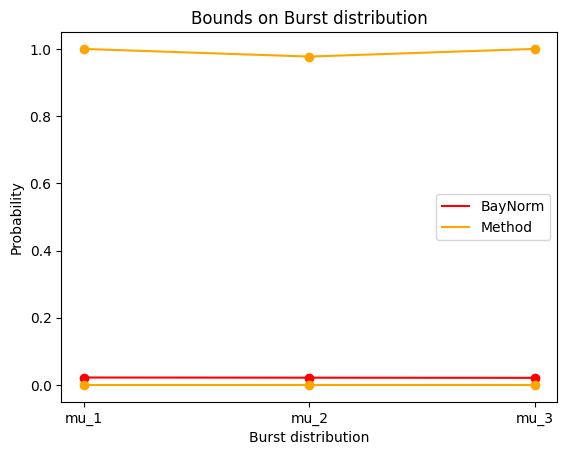

In [139]:
i = 46
result = LP_cast_concat.iloc[i]
b_est = prior_cast_concat.iloc[i]['B_EST']
plot_dist(result, b_est=b_est)

In [134]:
def sankey_plot(data_categories):
    data_categories_feasible = data_categories[data_categories['infeasible'] == False]
    upper_bound_list = []
    for i in range(data_categories_feasible.shape[0]):
        if data_categories_feasible['decreasing_ub'].iloc[i] == True and data_categories_feasible['increasing_ub'].iloc[i] == True:
            upper_bound_list.append(5)
        elif data_categories_feasible['increasing_ub'].iloc[i] == True:
            upper_bound_list.append(6)
        elif data_categories_feasible['decreasing_ub'].iloc[i] == True:
            upper_bound_list.append(7)
        else:
            upper_bound_list.append(8)

    label_list = ['genes', 'feasible', 'infeasible', 'zero lb', 'non-zero lb', 'flat ub', 'increasing ub', 'decreasing ub', 'mixture']
    # all start at 0: 'genes'
    source = [0 for i in range(data_categories.shape[0])] + \
            [1 for i in range(data_categories_feasible.shape[0])] + \
            [3 if flag else 4 for flag in data_categories_feasible['zero_lb']]
    # True / False of category decides target
    target = [2 if flag else 1 for flag in data_categories['infeasible']] + \
            [3 if flag else 4 for flag in data_categories_feasible['zero_lb']] + \
            upper_bound_list
    # all have equal weight
    count = [1 for i in source]

    fig = go.Figure(data=[go.Sankey(
        node = {"label": label_list},
        link = {"source": source, "target": target, "value": count, "color": "lightgrey"}
        )])
    fig.update_layout(font_size=15)
    fig.show()

In [ ]:
sankey_plot(CAT_NLP_cast_concat)